# Comprehensive TTS Model Evaluation on Test Dataset

Evaluate all 4 TTS ablation variants on the test dataset with multiple metrics:
- **V0**: LoRA (r=16, alpha=32)
- **V1**: LoRA (r=16, alpha=32)
- **V2**: LoRA (r=4, alpha=8)
- **V3**: LoRA (r=8, alpha=16)

## Evaluation Metrics
1. **Mel Cepstral Distortion (MCD)** - Spectral quality metric (lower is better)
2. **F0 (Pitch) Metrics** - RMSE, correlation, voicing error
3. **Duration Metrics** - Length ratio, duration error
4. **Audio Quality Metrics** - SNR, spectral distance
5. **Per-Domain Performance** - Breakdown by legal domain
6. **Per-Voice Performance** - Breakdown by TTS voice
7. **Inference Speed** - Processing time per sample
8. **Audio Length Analysis** - Generated vs reference duration

## 1. Installation

In [1]:
%pip install -q transformers datasets accelerate peft torchaudio librosa jiwer soundfile matplotlib seaborn pandas numpy tqdm uroman scipy pyworld


[notice] A new release of pip is available: 23.0.1 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


## 2. Imports

In [2]:
import os
import torch
import pandas as pd
import numpy as np
from pathlib import Path
import librosa
import soundfile as sf
import scipy.io.wavfile
from tqdm import tqdm
import time
import warnings
warnings.filterwarnings('ignore')

from transformers import (
    VitsModel,
    AutoTokenizer
)

from peft import PeftModel
import matplotlib.pyplot as plt
import seaborn as sns
import uroman
from scipy import signal
from scipy.stats import pearsonr

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")
    print(f"CUDA memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

PyTorch version: 2.9.1
CUDA available: False


## 3. Configuration

In [3]:
# Dataset paths
AUDIO_DIR = "Dataset_4.0h/audio"
TEST_CSV = "Dataset_4.0h/test.csv"

# Model paths
BASE_MODEL = "facebook/mms-tts-amh"

MODEL_PATHS = {
    'V0': "models/tts/mms_tts_lora_v0_final",
    'V1': "models/tts/mms_tts_lora_v1_final",
    'V2': "models/tts/mms_tts_lora_v2_final",
    'V3': "models/tts/mms_tts_lora_v3_final"
}

MODEL_LABELS = {
    'V0': 'V0: LoRA (r=16, α=32)',
    'V1': 'V1: LoRA (r=16, α=32)',
    'V2': 'V2: LoRA (r=4, α=8)',
    'V3': 'V3: LoRA (r=8, α=16)'
}

MODEL_COLORS = {
    'V0': '#1f77b4',
    'V1': '#ff7f0e',
    'V2': '#2ca02c',
    'V3': '#d62728'
}

# Audio parameters
TARGET_SR = 16000  # VITS models use 16kHz

print("Configuration loaded")

Configuration loaded


## 4. Load Test Dataset

In [4]:
def load_test_dataset(csv_path, audio_dir):
    """Load test dataset with metadata"""
    df = pd.read_csv(csv_path)
    
    data = []
    for _, row in df.iterrows():
        audio_path = Path(audio_dir) / row['file_name']
        if audio_path.exists():
            data.append({
                'file_name': row['file_name'],
                'audio_path': str(audio_path),
                'transcription': row['transcription'],
                'domain': row.get('domain_name', 'Unknown'),
                'voice': row.get('voice', 'Unknown')
            })
        else:
            print(f"Warning: Audio file not found: {audio_path}")
    
    return pd.DataFrame(data)

test_df = load_test_dataset(TEST_CSV, AUDIO_DIR)
print(f"Test dataset loaded: {len(test_df)} samples")
print(f"Domains: {test_df['domain'].value_counts().to_dict()}")
print(f"Voices: {test_df['voice'].value_counts().to_dict()}")
test_df.head()

Test dataset loaded: 103 samples
Domains: {'Unknown': 103}
Voices: {'Unknown': 103}


,file_name,audio_path,transcription,domain,voice
0,000719_mekdes.wav,Dataset_4.0h/audio/000719_mekdes.wav,የንግድ ምልክት ዝውውር ህጋዊ ውጤት የሚኖረው በንግድ መዝገብ ውስጥ ሲመዘ...,Unknown,Unknown
1,000724_mekdes.wav,Dataset_4.0h/audio/000724_mekdes.wav,በዚህ የድንበር ስምምነት መሰረት ሁለቱም ሀገራት የየራሳቸውን የግዛት አን...,Unknown,Unknown
2,000295_ameha.wav,Dataset_4.0h/audio/000295_ameha.wav,ማንኛውም ህዝባዊ ምርጫ በፍትሃዊነት እና በነጻነት የሚካሄድ መሆኑን የማረ...,Unknown,Unknown
3,000701_gtts_aug1.wav,Dataset_4.0h/audio/000701_gtts_aug1.wav,የንግድ ማህበር ስራ አስኪያጅ በጤና እክል ወይም በሌላ በቂ ምክንያት ስራ...,Unknown,Unknown
4,000251_ameha_aug1.wav,Dataset_4.0h/audio/000251_ameha_aug1.wav,በወንጀል ህግ መሰረት ጥፋተኛ ተብሎ የተወሰነበት ሰው የቅጣት ውሳኔው ከጸ...,Unknown,Unknown


## 5. Romanize Text

In [5]:
# Initialize uroman
try:
    uroman_obj = uroman.Uroman()
    print("Uroman initialized successfully")
except Exception as e:
    print(f"Error initializing uroman: {e}")
    uroman_obj = None

def romanize_text(text):
    """Convert Ge'ez script Amharic text to Romanized format using uroman"""
    if uroman_obj is None:
        return text
    
    try:
        romanized = uroman_obj.romanize_string(text)
        return romanized.strip()
    except Exception as e:
        print(f"Error romanizing text: {text[:50]}... Error: {e}")
        return text

# Romanize all transcriptions
print("Romanizing test transcriptions...")
test_df['transcription_romanized'] = test_df['transcription'].apply(romanize_text)
print(f"Sample - Original: {test_df.iloc[0]['transcription']}")
print(f"Sample - Romanized: {test_df.iloc[0]['transcription_romanized']}")

Uroman initialized successfully
Romanizing test transcriptions...
Sample - Original: የንግድ ምልክት ዝውውር ህጋዊ ውጤት የሚኖረው በንግድ መዝገብ ውስጥ ሲመዘገብ ብቻ ሲሆን ዝውውሩ የተደረገው በሽያጭ ወይም በስጦታ መሆኑ በውሉ ላይ በግልጽ መቀመጥ እና በሁለቱ ወገኖች ፊርማ ተረጋግጦ ለሚመለከተው አካል መቅረብ አለበት ።
Sample - Romanized: yanegede melekete zewewere hegaawi weteete yaminorawe banegede mazegabe wesete simazagabe bechaa sihone zeweweru yatadaragawe basheyaache wayeme basetotaa mahonu bawelu laaye bageletse maqamate enaa bahulatu waganoche firemaa taragaageto lamimalakatawe akaale maqerabe alabate .


## 6. Load All Models

In [ ]:
def load_tts_model(model_path, base_model_name):
    """Load a trained TTS model (with or without LoRA)"""
    tokenizer = AutoTokenizer.from_pretrained(model_path)
    
    # Check if LoRA adapters exist
    adapter_config = Path(model_path) / "adapter_config.json"
    adapter_bin = Path(model_path) / "adapter_model.bin"
    adapter_safetensors = Path(model_path) / "adapter_model.safetensors"
    
    if adapter_config.exists() or adapter_bin.exists() or adapter_safetensors.exists():
        base_model = VitsModel.from_pretrained(base_model_name)
        model = PeftModel.from_pretrained(base_model, model_path)
        print(f"Loaded LoRA model from {model_path}")
    else:
        model = VitsModel.from_pretrained(model_path)
        print(f"Loaded full model from {model_path}")
    
    model.eval()
    if torch.cuda.is_available():
        model = model.to("cuda")
    
    return model, tokenizer

# Load all models
models = {}
tokenizers = {}

for model_key, model_path in MODEL_PATHS.items():
    try:
        model, tokenizer = load_tts_model(model_path, BASE_MODEL)
        models[model_key] = model
        tokenizers[model_key] = tokenizer
        print(f"✓ {MODEL_LABELS[model_key]} loaded successfully\n")
    except Exception as e:
        print(f"✗ Failed to load {MODEL_LABELS[model_key]}: {e}\n")

print(f"\nLoaded {len(models)} models successfully")

# Patch PEFT models to filter out inputs_embeds (VitsModel doesn't accept it)
import functools

def create_patched_forward(original_forward):
    """Create a patched forward function that filters out unsupported arguments"""
    @functools.wraps(original_forward)
    def patched_forward(*args, **kwargs):
        # Remove inputs_embeds if present (VitsModel doesn't accept it)
        kwargs.pop('inputs_embeds', None)
        # Also remove task_ids which PEFT might pass
        kwargs.pop('task_ids', None)
        # Filter to only valid VitsModel arguments
        valid_kwargs = {k: v for k, v in kwargs.items() 
                        if k in ['input_ids', 'attention_mask', 'speaker_id', 
                                'output_attentions', 'output_hidden_states', 'return_dict', 'labels']}
        # Call the original forward with filtered kwargs
        return original_forward(*args, **valid_kwargs)
    return patched_forward

for model_key, model in models.items():
    if isinstance(model, PeftModel):
        # Patch the PEFT wrapper's forward method
        model.forward = create_patched_forward(model.forward)
        
        # CRITICAL: Also patch the base model's forward method
        # PEFT may call base_model.forward() directly, bypassing the wrapper
        if hasattr(model, 'base_model'):
            # Patch base_model.forward
            if hasattr(model.base_model, 'forward'):
                model.base_model.forward = create_patched_forward(model.base_model.forward)
            
            # Also check if base_model has a nested 'model' attribute (common in PEFT)
            if hasattr(model.base_model, 'model') and hasattr(model.base_model.model, 'forward'):
                model.base_model.model.forward = create_patched_forward(model.base_model.model.forward)
            
            # Recursively patch any nested base_model structures
            current = model.base_model
            depth = 0
            max_depth = 5  # Safety limit
            while depth < max_depth:
                if hasattr(current, 'forward'):
                    current.forward = create_patched_forward(current.forward)
                
                # Move to next level
                if hasattr(current, 'base_model'):
                    current = current.base_model
                elif hasattr(current, 'model'):
                    current = current.model
                else:
                    break
                depth += 1

print("Patched PEFT models (including base_model) to filter out unsupported arguments (inputs_embeds, etc.)")

Loaded LoRA model from models/tts/mms_tts_lora_v0_final
✓ V0: LoRA (r=16, α=32) loaded successfully

Loaded LoRA model from models/tts/mms_tts_lora_v1_final
✓ V1: LoRA (r=16, α=32) loaded successfully

Loaded LoRA model from models/tts/mms_tts_lora_v2_final
✓ V2: LoRA (r=4, α=8) loaded successfully

Loaded LoRA model from models/tts/mms_tts_lora_v3_final
✓ V3: LoRA (r=8, α=16) loaded successfully


Loaded 4 models successfully
Patched PEFT models (including base_model) to filter out unsupported arguments (inputs_embeds, etc.)


## 7. TTS Evaluation Functions

In [7]:
def compute_mel_cepstral_distortion(ref_audio, gen_audio, sr=16000, n_mels=80, n_fft=1024, hop_length=256):
    """Compute Mel Cepstral Distortion (MCD) between reference and generated audio"""
    try:
        # Compute mel spectrograms
        ref_mel = librosa.feature.melspectrogram(
            y=ref_audio, sr=sr, n_mels=n_mels, n_fft=n_fft, hop_length=hop_length
        )
        gen_mel = librosa.feature.melspectrogram(
            y=gen_audio, sr=sr, n_mels=n_mels, n_fft=n_fft, hop_length=hop_length
        )
        
        # Convert to log scale
        ref_mel_db = librosa.power_to_db(ref_mel, ref=np.max)
        gen_mel_db = librosa.power_to_db(gen_mel, ref=np.max)
        
        # Align lengths
        min_len = min(ref_mel_db.shape[1], gen_mel_db.shape[1])
        ref_mel_db = ref_mel_db[:, :min_len]
        gen_mel_db = gen_mel_db[:, :min_len]
        
        # Compute MCD (mean squared difference)
        mcd = np.mean(np.sqrt(np.sum((ref_mel_db - gen_mel_db) ** 2, axis=0)))
        
        return mcd
    except Exception as e:
        print(f"Error computing MCD: {e}")
        return float('inf')

def compute_f0_metrics(ref_audio, gen_audio, sr=16000):
    """Compute F0 (pitch) metrics using librosa"""
    try:
        # Extract F0 using librosa
        ref_f0, _, _ = librosa.pyin(ref_audio, fmin=librosa.note_to_hz('C2'), fmax=librosa.note_to_hz('C7'), sr=sr)
        gen_f0, _, _ = librosa.pyin(gen_audio, fmin=librosa.note_to_hz('C2'), fmax=librosa.note_to_hz('C7'), sr=sr)
        
        # Remove NaN values
        ref_f0_clean = ref_f0[~np.isnan(ref_f0)]
        gen_f0_clean = gen_f0[~np.isnan(gen_f0)]
        
        if len(ref_f0_clean) == 0 or len(gen_f0_clean) == 0:
            return {
                'f0_rmse': float('inf'),
                'f0_correlation': 0.0,
                'voicing_error': 1.0
            }
        
        # Align lengths
        min_len = min(len(ref_f0_clean), len(gen_f0_clean))
        ref_f0_aligned = ref_f0_clean[:min_len]
        gen_f0_aligned = gen_f0_clean[:min_len]
        
        # Compute RMSE
        f0_rmse = np.sqrt(np.mean((ref_f0_aligned - gen_f0_aligned) ** 2))
        
        # Compute correlation
        if len(ref_f0_aligned) > 1:
            f0_correlation, _ = pearsonr(ref_f0_aligned, gen_f0_aligned)
            if np.isnan(f0_correlation):
                f0_correlation = 0.0
        else:
            f0_correlation = 0.0
        
        # Voicing error (percentage of frames where voicing differs)
        ref_voiced = ~np.isnan(ref_f0)
        gen_voiced = ~np.isnan(gen_f0)
        min_len_voiced = min(len(ref_voiced), len(gen_voiced))
        voicing_error = np.mean(ref_voiced[:min_len_voiced] != gen_voiced[:min_len_voiced])
        
        return {
            'f0_rmse': f0_rmse,
            'f0_correlation': f0_correlation,
            'voicing_error': voicing_error
        }
    except Exception as e:
        print(f"Error computing F0 metrics: {e}")
        return {
            'f0_rmse': float('inf'),
            'f0_correlation': 0.0,
            'voicing_error': 1.0
        }

def compute_duration_metrics(ref_audio, gen_audio, sr=16000):
    """Compute duration-related metrics"""
    ref_duration = len(ref_audio) / sr
    gen_duration = len(gen_audio) / sr
    
    duration_ratio = gen_duration / ref_duration if ref_duration > 0 else 1.0
    duration_error = abs(gen_duration - ref_duration)
    
    return {
        'duration_ratio': duration_ratio,
        'duration_error': duration_error,
        'ref_duration': ref_duration,
        'gen_duration': gen_duration
    }

def compute_audio_quality_metrics(ref_audio, gen_audio, sr=16000):
    """Compute audio quality metrics (SNR, spectral distance)"""
    try:
        # Align lengths
        min_len = min(len(ref_audio), len(gen_audio))
        ref_aligned = ref_audio[:min_len]
        gen_aligned = gen_audio[:min_len]
        
        # Compute SNR (Signal-to-Noise Ratio)
        signal_power = np.mean(ref_aligned ** 2)
        noise_power = np.mean((ref_aligned - gen_aligned) ** 2)
        snr = 10 * np.log10(signal_power / noise_power) if noise_power > 0 else float('inf')
        
        # Compute spectral distance
        ref_stft = librosa.stft(ref_aligned, n_fft=2048, hop_length=512)
        gen_stft = librosa.stft(gen_aligned, n_fft=2048, hop_length=512)
        
        ref_mag = np.abs(ref_stft)
        gen_mag = np.abs(gen_stft)
        
        # Align frequency bins
        min_freq = min(ref_mag.shape[0], gen_mag.shape[0])
        min_time = min(ref_mag.shape[1], gen_mag.shape[1])
        
        spectral_distance = np.mean(np.abs(ref_mag[:min_freq, :min_time] - gen_mag[:min_freq, :min_time]))
        
        return {
            'snr': snr,
            'spectral_distance': spectral_distance
        }
    except Exception as e:
        print(f"Error computing audio quality metrics: {e}")
        return {
            'snr': float('-inf'),
            'spectral_distance': float('inf')
        }

print("TTS evaluation functions defined")

TTS evaluation functions defined


In [8]:
def synthesize_audio(model, tokenizer, text_romanized, sr=16000):
    """Synthesize audio from romanized text"""
    try:
        # Tokenize
        inputs = tokenizer(text_romanized, return_tensors="pt")
        
        # Move to device
        if torch.cuda.is_available():
            inputs = {k: v.to("cuda") for k, v in inputs.items()}
        
        # Filter out inputs_embeds which VitsModel doesn't accept (safety check)
        valid_inputs = {k: v for k, v in inputs.items() 
                       if k in ['input_ids', 'attention_mask']}
        
        # Generate
        with torch.no_grad():
            output = model(**valid_inputs).waveform
        
        # Convert to numpy
        if isinstance(output, torch.Tensor):
            audio = output.cpu().numpy()
        else:
            audio = output
        
        # Ensure mono and correct shape
        if len(audio.shape) > 1:
            audio = audio[0] if audio.shape[0] == 1 else audio.mean(axis=0)
        
        # Resample if needed
        if sr != model.config.sampling_rate:
            audio = librosa.resample(audio, orig_sr=model.config.sampling_rate, target_sr=sr)
        
        return audio
    except Exception as e:
        print(f"Error synthesizing audio: {e}")
        return None

# Evaluate all models
results = {}

for model_key in models.keys():
    print(f"\nEvaluating {MODEL_LABELS[model_key]}...")
    
    model = models[model_key]
    tokenizer = tokenizers[model_key]
    
    generated_audios = []
    inference_times = []
    
    for idx, row in tqdm(test_df.iterrows(), total=len(test_df), desc=f"Processing {MODEL_LABELS[model_key]}"):
        start_time = time.time()
        
        audio = synthesize_audio(model, tokenizer, row['transcription_romanized'], sr=TARGET_SR)
        
        inference_time = time.time() - start_time
        
        generated_audios.append(audio)
        inference_times.append(inference_time)
    
    results[model_key] = {
        'generated_audios': generated_audios,
        'inference_times': inference_times
    }
    
    print(f"✓ Completed {MODEL_LABELS[model_key]}")

print("\nAll models evaluated!")


Evaluating V0: LoRA (r=16, α=32)...


Processing V0: LoRA (r=16, α=32): 100%|██████████| 103/103 [03:24<00:00,  1.98s/it]


✓ Completed V0: LoRA (r=16, α=32)

Evaluating V1: LoRA (r=16, α=32)...


Processing V1: LoRA (r=16, α=32): 100%|██████████| 103/103 [02:35<00:00,  1.51s/it]


✓ Completed V1: LoRA (r=16, α=32)

Evaluating V2: LoRA (r=4, α=8)...


Processing V2: LoRA (r=4, α=8): 100%|██████████| 103/103 [02:30<00:00,  1.46s/it]


✓ Completed V2: LoRA (r=4, α=8)

Evaluating V3: LoRA (r=8, α=16)...


Processing V3: LoRA (r=8, α=16): 100%|██████████| 103/103 [03:34<00:00,  2.08s/it]

✓ Completed V3: LoRA (r=8, α=16)

All models evaluated!


## 9. Compute All Metrics

In [9]:
# Load reference audios
print("Loading reference audios...")
reference_audios = []
for idx, row in tqdm(test_df.iterrows(), total=len(test_df), desc="Loading references"):
    audio, sr = librosa.load(row['audio_path'], sr=TARGET_SR)
    # Ensure mono
    if len(audio.shape) > 1:
        audio = audio[0] if audio.shape[0] == 1 else audio.mean(axis=0)
    reference_audios.append(audio)

print(f"Loaded {len(reference_audios)} reference audios")

# Compute metrics for each model
all_metrics = {}

for model_key in models.keys():
    print(f"\nComputing metrics for {MODEL_LABELS[model_key]}...")
    
    generated_audios = results[model_key]['generated_audios']
    
    # Initialize metric lists
    mcds = []
    f0_rmses = []
    f0_correlations = []
    voicing_errors = []
    duration_ratios = []
    duration_errors = []
    snrs = []
    spectral_distances = []
    
    for ref_audio, gen_audio in tqdm(zip(reference_audios, generated_audios), 
                                     total=len(reference_audios),
                                     desc=f"Computing {MODEL_LABELS[model_key]}"):
        if gen_audio is None:
            continue
        
        # MCD
        mcd = compute_mel_cepstral_distortion(ref_audio, gen_audio, sr=TARGET_SR)
        mcds.append(mcd)
        
        # F0 metrics
        f0_metrics = compute_f0_metrics(ref_audio, gen_audio, sr=TARGET_SR)
        f0_rmses.append(f0_metrics['f0_rmse'])
        f0_correlations.append(f0_metrics['f0_correlation'])
        voicing_errors.append(f0_metrics['voicing_error'])
        
        # Duration metrics
        duration_metrics = compute_duration_metrics(ref_audio, gen_audio, sr=TARGET_SR)
        duration_ratios.append(duration_metrics['duration_ratio'])
        duration_errors.append(duration_metrics['duration_error'])
        
        # Audio quality metrics
        quality_metrics = compute_audio_quality_metrics(ref_audio, gen_audio, sr=TARGET_SR)
        snrs.append(quality_metrics['snr'])
        spectral_distances.append(quality_metrics['spectral_distance'])
    
    # Filter out infinite values for aggregation
    def filter_inf(values):
        return [v for v in values if not np.isinf(v) and not np.isnan(v)]
    
    # Aggregate metrics
    all_metrics[model_key] = {
        'mcd': np.mean(filter_inf(mcds)),
        'f0_rmse': np.mean(filter_inf(f0_rmses)),
        'f0_correlation': np.mean(filter_inf(f0_correlations)),
        'voicing_error': np.mean(filter_inf(voicing_errors)),
        'duration_ratio': np.mean(filter_inf(duration_ratios)),
        'duration_error': np.mean(filter_inf(duration_errors)),
        'snr': np.mean(filter_inf(snrs)),
        'spectral_distance': np.mean(filter_inf(spectral_distances)),
        'avg_inference_time': np.mean(results[model_key]['inference_times']),
        'total_inference_time': np.sum(results[model_key]['inference_times'])
    }
    
    print(f"  MCD: {all_metrics[model_key]['mcd']:.4f}")
    print(f"  F0 RMSE: {all_metrics[model_key]['f0_rmse']:.4f}")
    print(f"  F0 Correlation: {all_metrics[model_key]['f0_correlation']:.4f}")
    print(f"  Duration Ratio: {all_metrics[model_key]['duration_ratio']:.4f}")
    print(f"  SNR: {all_metrics[model_key]['snr']:.4f}")

print("\nAll metrics computed!")

Loading reference audios...


Loading references: 100%|██████████| 103/103 [00:01<00:00, 75.11it/s]


Loaded 103 reference audios

Computing metrics for V0: LoRA (r=16, α=32)...


Computing V0: LoRA (r=16, α=32): 100%|██████████| 103/103 [05:50<00:00,  3.40s/it]


  MCD: 168.0004
  F0 RMSE: 87.3277
  F0 Correlation: 0.1010
  Duration Ratio: 1.3471
  SNR: -5.8340

Computing metrics for V1: LoRA (r=16, α=32)...


Computing V1: LoRA (r=16, α=32): 100%|██████████| 103/103 [05:44<00:00,  3.34s/it]


  MCD: 168.1760
  F0 RMSE: 87.4989
  F0 Correlation: 0.0938
  Duration Ratio: 1.3513
  SNR: -5.8249

Computing metrics for V2: LoRA (r=4, α=8)...


Computing V2: LoRA (r=4, α=8): 100%|██████████| 103/103 [05:40<00:00,  3.31s/it]


  MCD: 167.5496
  F0 RMSE: 86.6637
  F0 Correlation: 0.1066
  Duration Ratio: 1.3477
  SNR: -5.8625

Computing metrics for V3: LoRA (r=8, α=16)...


Computing V3: LoRA (r=8, α=16): 100%|██████████| 103/103 [05:17<00:00,  3.08s/it]

  MCD: 168.3170
  F0 RMSE: 87.6507
  F0 Correlation: 0.0845
  Duration Ratio: 1.3510
  SNR: -5.8035

All metrics computed!


## 10. Per-Domain and Per-Voice Analysis

In [ ]:
# Per-domain metrics
domain_metrics = {}
voice_metrics = {}

for model_key in models.keys():
    generated_audios = results[model_key]['generated_audios']
    
    # Per domain
    domain_metrics[model_key] = {}
    for domain in test_df['domain'].unique():
        domain_mask = test_df['domain'] == domain
        domain_refs = [ref for ref, mask in zip(reference_audios, domain_mask) if mask]
        domain_gens = [gen for gen, mask in zip(generated_audios, domain_mask) if mask]
        
        if len(domain_refs) > 0:
            domain_mcds = [compute_mel_cepstral_distortion(r, g, sr=TARGET_SR) 
                          for r, g in zip(domain_refs, domain_gens) if g is not None]
            domain_mcds = [m for m in domain_mcds if not np.isinf(m) and not np.isnan(m)]
            
            if len(domain_mcds) > 0:
                domain_metrics[model_key][domain] = {
                    'mcd': np.mean(domain_mcds),
                    'count': len(domain_mcds)
                }
    
    # Per voice
    voice_metrics[model_key] = {}
    for voice in test_df['voice'].unique():
        voice_mask = test_df['voice'] == voice
        voice_refs = [ref for ref, mask in zip(reference_audios, voice_mask) if mask]
        voice_gens = [gen for gen, mask in zip(generated_audios, voice_mask) if mask]
        
        if len(voice_refs) > 0:
            voice_mcds = [compute_mel_cepstral_distortion(r, g, sr=TARGET_SR) 
                        for r, g in zip(voice_refs, voice_gens) if g is not None]
            voice_mcds = [m for m in voice_mcds if not np.isinf(m) and not np.isnan(m)]
            
            if len(voice_mcds) > 0:
                voice_metrics[model_key][voice] = {
                    'mcd': np.mean(voice_mcds),
                    'count': len(voice_mcds)
                }

print("Per-domain and per-voice metrics computed!")

Per-domain and per-voice metrics computed!


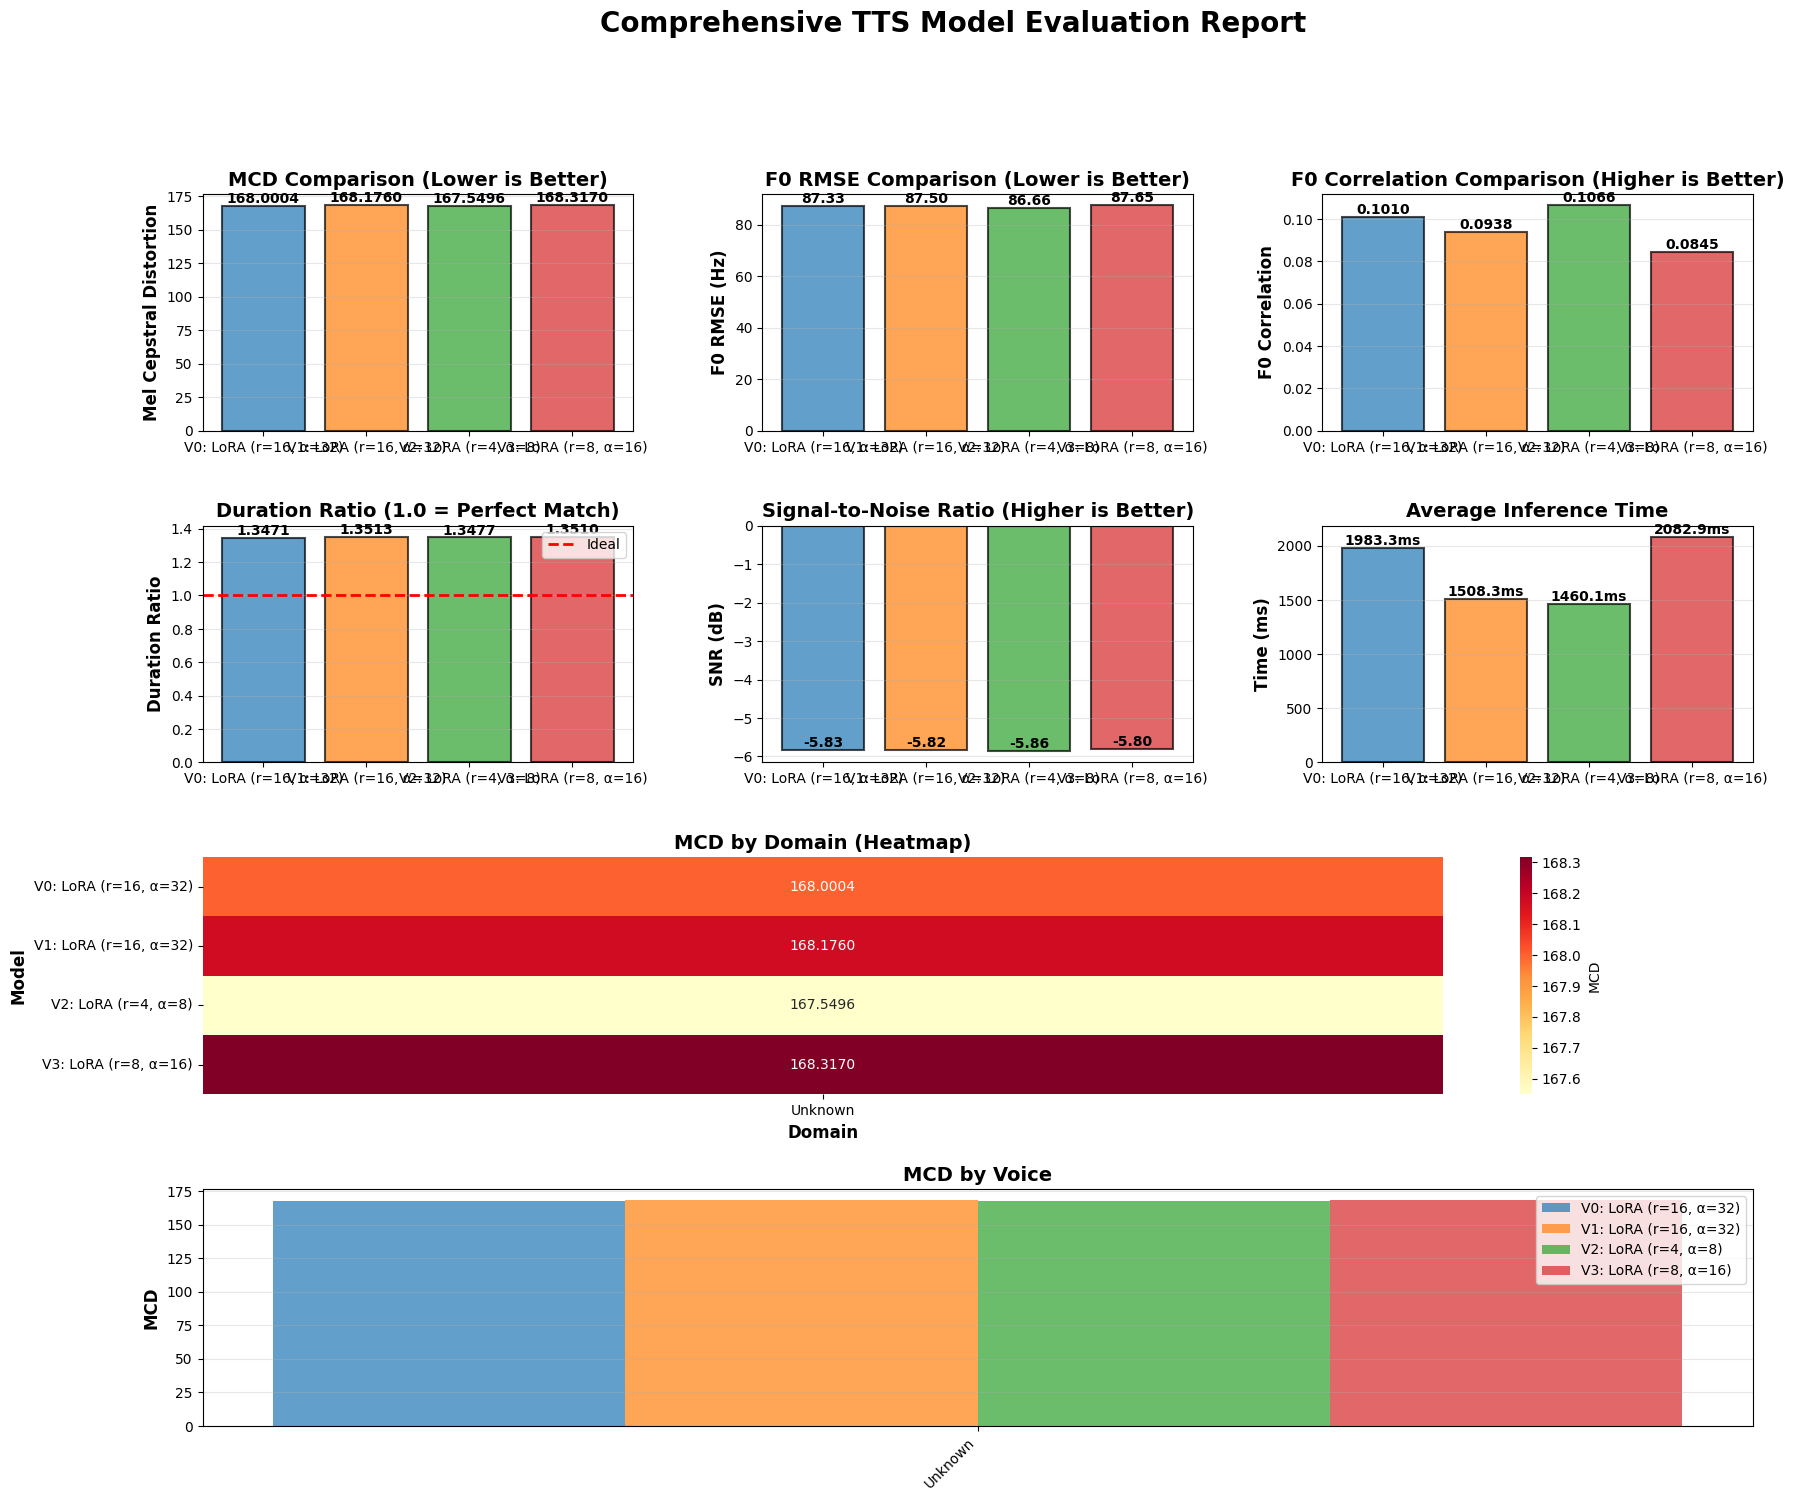


Evaluation report saved to: comprehensive_tts_evaluation_report.png


In [11]:
# Create comprehensive visualization report
fig = plt.figure(figsize=(20, 16))
gs = fig.add_gridspec(4, 3, hspace=0.4, wspace=0.3)

# 1. MCD Comparison
ax1 = fig.add_subplot(gs[0, 0])
model_names = [MODEL_LABELS[k] for k in models.keys()]
mcd_values = [all_metrics[k]['mcd'] for k in models.keys()]
colors = [MODEL_COLORS[k] for k in models.keys()]
bars = ax1.bar(model_names, mcd_values, color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)
ax1.set_ylabel('Mel Cepstral Distortion', fontsize=12, fontweight='bold')
ax1.set_title('MCD Comparison (Lower is Better)', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3, axis='y')
for bar, val in zip(bars, mcd_values):
    ax1.text(bar.get_x() + bar.get_width()/2., bar.get_height(),
            f'{val:.4f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

# 2. F0 RMSE Comparison
ax2 = fig.add_subplot(gs[0, 1])
f0_rmse_values = [all_metrics[k]['f0_rmse'] for k in models.keys()]
bars = ax2.bar(model_names, f0_rmse_values, color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)
ax2.set_ylabel('F0 RMSE (Hz)', fontsize=12, fontweight='bold')
ax2.set_title('F0 RMSE Comparison (Lower is Better)', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='y')
for bar, val in zip(bars, f0_rmse_values):
    ax2.text(bar.get_x() + bar.get_width()/2., bar.get_height(),
            f'{val:.2f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

# 3. F0 Correlation Comparison
ax3 = fig.add_subplot(gs[0, 2])
f0_corr_values = [all_metrics[k]['f0_correlation'] for k in models.keys()]
bars = ax3.bar(model_names, f0_corr_values, color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)
ax3.set_ylabel('F0 Correlation', fontsize=12, fontweight='bold')
ax3.set_title('F0 Correlation Comparison (Higher is Better)', fontsize=14, fontweight='bold')
ax3.grid(True, alpha=0.3, axis='y')
for bar, val in zip(bars, f0_corr_values):
    ax3.text(bar.get_x() + bar.get_width()/2., bar.get_height(),
            f'{val:.4f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

# 4. Duration Ratio
ax4 = fig.add_subplot(gs[1, 0])
duration_ratios = [all_metrics[k]['duration_ratio'] for k in models.keys()]
bars = ax4.bar(model_names, duration_ratios, color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)
ax4.set_ylabel('Duration Ratio', fontsize=12, fontweight='bold')
ax4.set_title('Duration Ratio (1.0 = Perfect Match)', fontsize=14, fontweight='bold')
ax4.axhline(y=1.0, color='r', linestyle='--', linewidth=2, label='Ideal')
ax4.grid(True, alpha=0.3, axis='y')
ax4.legend()
for bar, val in zip(bars, duration_ratios):
    ax4.text(bar.get_x() + bar.get_width()/2., bar.get_height(),
            f'{val:.4f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

# 5. SNR Comparison
ax5 = fig.add_subplot(gs[1, 1])
snr_values = [all_metrics[k]['snr'] for k in models.keys()]
bars = ax5.bar(model_names, snr_values, color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)
ax5.set_ylabel('SNR (dB)', fontsize=12, fontweight='bold')
ax5.set_title('Signal-to-Noise Ratio (Higher is Better)', fontsize=14, fontweight='bold')
ax5.grid(True, alpha=0.3, axis='y')
for bar, val in zip(bars, snr_values):
    ax5.text(bar.get_x() + bar.get_width()/2., bar.get_height(),
            f'{val:.2f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

# 6. Inference Speed
ax6 = fig.add_subplot(gs[1, 2])
inf_times = [all_metrics[k]['avg_inference_time'] * 1000 for k in models.keys()]  # Convert to ms
bars = ax6.bar(model_names, inf_times, color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)
ax6.set_ylabel('Time (ms)', fontsize=12, fontweight='bold')
ax6.set_title('Average Inference Time', fontsize=14, fontweight='bold')
ax6.grid(True, alpha=0.3, axis='y')
for bar, val in zip(bars, inf_times):
    ax6.text(bar.get_x() + bar.get_width()/2., bar.get_height(),
            f'{val:.1f}ms', ha='center', va='bottom', fontsize=10, fontweight='bold')

# 7. Per-Domain MCD Heatmap
ax7 = fig.add_subplot(gs[2, :])
domain_mcd_data = []
for model_key in models.keys():
    row = []
    for domain in sorted(test_df['domain'].unique()):
        if domain in domain_metrics[model_key]:
            row.append(domain_metrics[model_key][domain]['mcd'])
        else:
            row.append(np.nan)
    domain_mcd_data.append(row)
domain_mcd_df = pd.DataFrame(domain_mcd_data, 
                            index=[MODEL_LABELS[k] for k in models.keys()],
                            columns=sorted(test_df['domain'].unique()))
sns.heatmap(domain_mcd_df, annot=True, fmt='.4f', cmap='YlOrRd', ax=ax7, cbar_kws={'label': 'MCD'})
ax7.set_title('MCD by Domain (Heatmap)', fontsize=14, fontweight='bold')
ax7.set_xlabel('Domain', fontsize=12, fontweight='bold')
ax7.set_ylabel('Model', fontsize=12, fontweight='bold')

# 8. Per-Voice MCD Comparison
ax8 = fig.add_subplot(gs[3, :])
voice_mcd_data = {}
for model_key in models.keys():
    voice_mcds = []
    voice_labels = []
    for voice in sorted(test_df['voice'].unique()):
        if voice in voice_metrics[model_key]:
            voice_mcds.append(voice_metrics[model_key][voice]['mcd'])
            voice_labels.append(voice)
    voice_mcd_data[MODEL_LABELS[model_key]] = voice_mcds

x = np.arange(len(sorted(test_df['voice'].unique())))
width = 0.2
for i, (label, mcds) in enumerate(voice_mcd_data.items()):
    offset = (i - len(voice_mcd_data)/2) * width + width/2
    ax8.bar(x + offset, mcds, width, label=label, alpha=0.7)
ax8.set_ylabel('MCD', fontsize=12, fontweight='bold')
ax8.set_title('MCD by Voice', fontsize=14, fontweight='bold')
ax8.set_xticks(x)
ax8.set_xticklabels(sorted(test_df['voice'].unique()), rotation=45, ha='right')
ax8.legend()
ax8.grid(True, alpha=0.3, axis='y')

fig.suptitle('Comprehensive TTS Model Evaluation Report', fontsize=20, fontweight='bold', y=0.995)
plt.tight_layout(rect=[0, 0, 1, 0.99])
plt.show()

# Save plot
fig.savefig('comprehensive_tts_evaluation_report.png', dpi=300, bbox_inches='tight', facecolor='white')
print("\nEvaluation report saved to: comprehensive_tts_evaluation_report.png")

## 12. Summary Tablers

In [12]:
# Create comprehensive summary table
summary_data = []
for model_key in models.keys():
    summary_data.append({
        'Model': MODEL_LABELS[model_key],
        'MCD': f"{all_metrics[model_key]['mcd']:.4f}",
        'F0 RMSE': f"{all_metrics[model_key]['f0_rmse']:.2f}",
        'F0 Correlation': f"{all_metrics[model_key]['f0_correlation']:.4f}",
        'Voicing Error': f"{all_metrics[model_key]['voicing_error']:.4f}",
        'Duration Ratio': f"{all_metrics[model_key]['duration_ratio']:.4f}",
        'Duration Error (s)': f"{all_metrics[model_key]['duration_error']:.4f}",
        'SNR (dB)': f"{all_metrics[model_key]['snr']:.2f}",
        'Spectral Distance': f"{all_metrics[model_key]['spectral_distance']:.4f}",
        'Inf Time (ms)': f"{all_metrics[model_key]['avg_inference_time']*1000:.2f}"
    })

summary_df = pd.DataFrame(summary_data)

print("\n" + "="*120)
print("COMPREHENSIVE TTS EVALUATION SUMMARY")
print("="*120)
print(summary_df.to_string(index=False))
print("="*120)

# Save to CSV
summary_df.to_csv('tts_evaluation_summary.csv', index=False)
print("\nSummary saved to: tts_evaluation_summary.csv")


COMPREHENSIVE TTS EVALUATION SUMMARY
                Model      MCD F0 RMSE F0 Correlation Voicing Error Duration Ratio Duration Error (s) SNR (dB) Spectral Distance Inf Time (ms)
V0: LoRA (r=16, α=32) 168.0004   87.33         0.1010        0.4286         1.3471             4.7320    -5.83            0.6718       1983.29
V1: LoRA (r=16, α=32) 168.1760   87.50         0.0938        0.4288         1.3513             4.7923    -5.82            0.6688       1508.29
  V2: LoRA (r=4, α=8) 167.5496   86.66         0.1066        0.4208         1.3477             4.7442    -5.86            0.6704       1460.15
 V3: LoRA (r=8, α=16) 168.3170   87.65         0.0845        0.4253         1.3510             4.7620    -5.80            0.6682       2082.87

Summary saved to: tts_evaluation_summary.csv


## 13. Detailed Results Export

In [ ]:
# Export detailed results for each model
for model_key in models.keys():
    detailed_results = test_df.copy()
    detailed_results['inference_time'] = results[model_key]['inference_times']
    
    # Compute per-sample metrics
    mcds = []
    f0_rmses = []
    f0_corrs = []
    duration_ratios = []
    
    for ref_audio, gen_audio in zip(reference_audios, results[model_key]['generated_audios']):
        if gen_audio is None:
            mcds.append(np.nan)
            f0_rmses.append(np.nan)
            f0_corrs.append(np.nan)
            duration_ratios.append(np.nan)
            continue
        
        mcd = compute_mel_cepstral_distortion(ref_audio, gen_audio, sr=TARGET_SR)
        f0_metrics = compute_f0_metrics(ref_audio, gen_audio, sr=TARGET_SR)
        duration_metrics = compute_duration_metrics(ref_audio, gen_audio, sr=TARGET_SR)
        
        mcds.append(mcd if not np.isinf(mcd) else np.nan)
        f0_rmses.append(f0_metrics['f0_rmse'] if not np.isinf(f0_metrics['f0_rmse']) else np.nan)
        f0_corrs.append(f0_metrics['f0_correlation'])
        duration_ratios.append(duration_metrics['duration_ratio'])
    
    detailed_results['mcd'] = mcds
    detailed_results['f0_rmse'] = f0_rmses
    detailed_results['f0_correlation'] = f0_corrs
    detailed_results['duration_ratio'] = duration_ratios
    
    # Save
    output_file = f"detailed_tts_results_{model_key}.csv"
    detailed_results.to_csv(output_file, index=False)
    print(f"Detailed results saved: {output_file}")

print("\nAll detailed results exported!")

Error computing F0 metrics: CPUDispatcher(<function _viterbi at 0x160f068c0>) returned a result with an exception set
